In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
%load_ext autoreload
%autoreload 2
%run '../../main.py'

In [3]:
dataSetOps = DataSetOps()

mul = 10000

dataSetOps.import_years(2017, 2017)
dataSetOps.df['max'] = dataSetOps.df['max'] * mul
dataSetOps.df['min'] = dataSetOps.df['min'] * mul
dataSetOps.df['open'] = dataSetOps.df['open'] * mul
dataSetOps.df['price'] = dataSetOps.df['price'] * mul

dataSetOps.prepare()


df = dataSetOps.df

In [4]:
# print(df)
# variables
mavglar = [30, 50, 70]
window = 15
spread = 1.5
epilson = spread * mul / 10000

In [5]:
df['value'] = True
for mavgl in mavglar:
    mavgl = str(mavgl)
    df['f_mavg' + mavgl] = df['mavg' + mavgl].shift(-window).rolling(window=50).mean()
    df['value'] = df['value'] & (df['f_mavg' + mavgl] - df['mavg' + mavgl] > epilson)
    #df[['price', 'mavg' + mavgl, 'mavg10', 'f_mavg' + mavgl]].head(1000).plot()
    
    
df['f_price'] = df['price'].shift(-window).rolling(window=window).max()
df['value_real'] = df['f_price'] - df['price'] > epilson

pattern prob 10.53125877443529 %
pattern total prob 5.86941799569925 %
370633


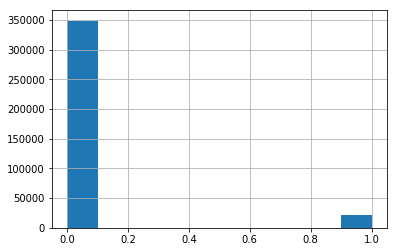

In [6]:
df['value'].astype(int).hist()
print('pattern prob', (len(df[df['value']]) / (len(df[df['value_real']]))) * 100, '%')
print('pattern total prob', (len(df[df['value']]) / (len(df))) * 100, '%')
print(len(df))

In [7]:
X = df[['price', 'mavg10', 'mavg20', 'mavg50', 'mavg80', 'mavg100', 'mavg1000']]
Y = df['value']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

    
#Initializing Neural Network
classifier = Sequential()

class1 = Dense(output_dim = 16, init = 'uniform', activation = 'relu', input_dim = 7)
class2 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
class3 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
# Adding the input layer and the first hidden layer
classifier.add(class1)
# Adding the second hidden layer
classifier.add(class2)
classifier.add(class3)
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
from keras import metrics
metric_names = [metrics.mae, 'accuracy']
classifier.compile(optimizer='adam', loss = 'mean_squared_error', metrics=metric_names)


# Fitting our model 
classifier.fit(X_train, y_train, batch_size = 20, epochs = 7)
import random
classifier.save("/tmp/mavg_classifier_" + str(random.randint(100000, 999999)))

Using TensorFlow backend.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=7, units=16, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  if sys.path[0] == '':
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


Epoch 1/7
333569/333569 [==============================] - 7s 22us/step - loss: 0.0543 - mean_absolute_error: 0.1095 - acc: 0.9415
Epoch 2/7
333569/333569 [==============================] - 7s 22us/step - loss: 0.0462 - mean_absolute_error: 0.0919 - acc: 0.9431
Epoch 3/7
333569/333569 [==============================] - 7s 22us/step - loss: 0.0396 - mean_absolute_error: 0.0787 - acc: 0.9500
Epoch 4/7
333569/333569 [==============================] - 7s 21us/step - loss: 0.0353 - mean_absolute_error: 0.0705 - acc: 0.9545
Epoch 5/7
333569/333569 [==============================] - 7s 21us/step - loss: 0.0342 - mean_absolute_error: 0.0681 - acc: 0.9553
Epoch 6/7
333569/333569 [==============================] - 7s 21us/step - loss: 0.0333 - mean_absolute_error: 0.0661 - acc: 0.9563
Epoch 7/7
333569/333569 [==============================] - 7s 22us/step - loss: 0.0323 - mean_absolute_error: 0.0642 - acc: 0.9574


In [9]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
from lib.helper import AccuracyCalculator

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, (y_pred > 0.8))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_pred[:,0], y_test, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_pred[:,0], y_test)


class_accuracy => accuracy:  0.5984087115546869 risk:  0.126232741617357
optimistic_accuracy => risk:  0.11 min pass point:  0.85174793


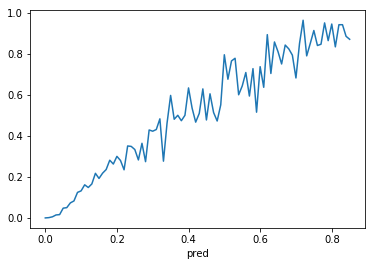

In [10]:
(1-risk_hist_df.risk).plot()

In [11]:
cm

array([[34770,    64],
       [ 1787,   443]])

In [12]:
dfx = df[df['value']]
p_f = len(dfx[dfx['value_real']]) / len(dfx)
p_r = cm[1,1] / (cm[1,1] + cm[0,1])
print('real prob', p_f , p_r, p_f * p_r)

real prob 0.7248322147651006 0.873767258382643 0.6333346570827211


class_accuracy => accuracy:  0.5058880847084988 risk:  0.22918318794607453
optimistic_accuracy => risk:  0.23 min pass point:  0.85174793
[[162911   1156]
 [202678   3888]]


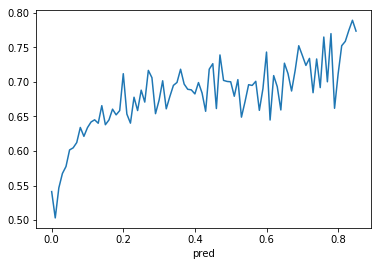

In [13]:
y_all_pred = classifier.predict(sc.transform(X))
y_f_price_real = df['value_real']
cm = confusion_matrix(y_f_price_real, (y_all_pred > 0.8))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_all_pred[:,0], y_f_price_real, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_all_pred[:,0], y_f_price_real)

print(cm)

(1-risk_hist_df.risk).plot()



0.7248322147651006
21754


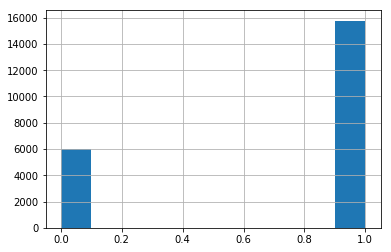

In [14]:
dfr = df[df['value']]
dfr['value_real'].astype(int).hist()
print(len(dfr[dfr['value_real']]) / (len(dfr)))
print(len(dfr['value_real']))